# CIELAB plotting
#### Goal：
* build a 3D CIELAB sphere 
* plot output points ✔️
* plot surfaces ✔️
* plot polygon ✔️
* plot color chart points ✔️
* change the marker ✔️

In [722]:
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color
from scipy.spatial import ConvexHull
import cv2
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

In [723]:
def plotLAB(output, draw_polygon=True, marker='o'):
    # compute convex hull of the given points
    hull = ConvexHull(output[:, 1:])
    if draw_polygon:
        # plot the convex hull boundary
#         for i in range(hull.vertices.shape[0]):
#             j = (i + 1) % hull.vertices.shape[0]
#             pt1, pt2 = output[hull.vertices[i]], output[hull.vertices[j]]
#             ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], [pt1[2], pt2[2]], color='black')

          # connect original points with gradient color
        for i in range(output.shape[0]):
            pt1, pt2 = output[i], output[(i + 1) % output.shape[0]]
            
            # create a gradient colormap between two colors
            x = color.lab2rgb(pt1)
            y = color.lab2rgb(pt2)
            cmap = LinearSegmentedColormap.from_list('', [x, y], N=100)
            c = np.linspace(0, 1, 100)
            # plot each segment as a line with the gradient colormap
            ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], [pt1[2], pt2[2]], 
                    c=c, cmap=cmap,alpha=0.5)
        
    # plot the original points
    for i in range(output.shape[0]):
        lab = output[i]
        rgb = color.lab2rgb(np.array([lab]))
        rgb = np.clip(rgb, 0, 1)
        ax.scatter(*lab, color=rgb[0], marker=marker)


        
def convert_model_output(arr, value, index):
    arr = np.unique(arr, axis=0)
    arr = np.insert(arr, index, value, axis=1)
    # convert to LAB and adjust L
    lab_colors = arr.copy()
    #     lab_colors[:, 0] = 50  # adjust L to 50
    lab_colors = color.lab2rgb(lab_colors)  # convert to RGB
    lab_colors = np.clip(lab_colors * 255, 0, 255).astype(int)  # convert to integer RGB values
    # create DataFrame with both LAB and RGB columns
    df_lab = pd.DataFrame(arr, columns=['L', 'a', 'b'])
    df_rgb = pd.DataFrame(lab_colors, columns=['R', 'G', 'B'])
    df = pd.concat([df_rgb ,df_lab], axis=1)
    return df

def convert_color_chart(color_codes, to_lab=True, adjust_L=True):
    # parse color codes
    original_codes = color_codes.copy()  
    color_codes = [c.lstrip('#') for c in color_codes]
    # convert to RGB
    rgb_colors = np.array([[int(c[i:i+2], 16) for i in (0, 2, 4)] for c in color_codes]) / 255.0

    if to_lab:
        # convert to LAB
        lab_colors = color.rgb2lab(rgb_colors)
        if adjust_L:
            lab_colors[:, 0] = 50  # adjust L to 50
            rgb_colors = color.lab2rgb(lab_colors) * 255
            rgb_colors = np.clip(rgb_colors, 0, 255)  
        df_rgb = pd.DataFrame(rgb_colors, columns=['R', 'G', 'B'])
        df_lab = pd.DataFrame(lab_colors, columns=['L', 'a', 'b'])
        df = df_lab.join(df_rgb)
    else:
        df_rgb = pd.DataFrame(rgb_colors, columns=['R', 'G', 'B'])
        df = df_rgb
    
    df['Color Code'] = original_codes
    return df[['Color Code', 'R', 'G', 'B', 'L', 'a', 'b']]


def plot_lab_plane(ax, L=50, a_range=(-128, 127, 100), b_range=(-128, 127, 100)):
    A, B = np.meshgrid(np.linspace(*a_range), np.linspace(*b_range))
    L = np.ones_like(A) * L
    lab_plane = np.stack([L, A, B], axis=-1)
    rgb_plane = color.lab2rgb(lab_plane)
    ax.plot_surface(L, A, B, facecolors=rgb_plane, alpha=0.2)

def set_lab_color_space(ax):
    ax.set_xlabel('L')
    ax.set_ylabel('a')
    ax.set_zlabel('b')
    ax.set_xlim3d(0, 100)
    ax.set_ylim3d(-128, 127)
    ax.set_zlim3d(-128, 127)
    plt.show()

### Color Extract Categorization

In [724]:
# read image and flatten pixel values
im = cv2.imread("output.png")
flat_im = im.reshape(-1, 3)

# convert RGB to CIELAB
lab_im = color.rgb2lab(flat_im.reshape(im.shape))

# get unique color values and their counts
color_categories = np.unique(lab_im.reshape(-1, 3), axis=0, return_counts=True)

# create pandas dataframe
df = pd.DataFrame(data=color_categories[0], columns=['L', 'a', 'b'])
df['count'] = color_categories[1]

# display dataframe
df

,L,a,b,count
0,44.117674,-10.942124,-30.197596,449
1,44.126965,-10.893107,-30.182378,27
2,44.444639,-11.475817,-29.685203,8
3,44.453830,-11.426993,-29.670157,1
4,44.463019,-11.378220,-29.655117,1
...,...,...,...,...
1216,99.728483,0.327030,0.120872,105
1217,99.753424,0.501825,-0.355518,7
1218,99.926784,-0.331240,-0.111047,12
1219,99.975165,-0.177075,0.480887,5


### Data（Output） Preprocessing

In [725]:
# Model Output
output = np.array([[4.79, 81.1], [11.72, 40.82], [10.99, 35.12], [8.01, 58.43], [-6.36, -33.91], [30.93, -45.39], [30.93, -45.39], [30.93, -45.39]])
df_model_output = convert_model_output(output,50,0)
lab_model_output = df_model_output[['L', 'a', 'b']].values.astype(np.float32)
print(lab_model_output)
# Color Charts
color_codes = ['#424B54', '#93A8AC', '#FFFFFF', '#E2B4BD', '#9B6A6C']
df_color_chart = convert_color_chart(color_codes, to_lab=True, adjust_L=False)
lab_color_chart = df_color_chart[['L', 'a', 'b']].values.astype(np.float32)

[[ 50.    -6.36 -33.91]
 [ 50.     4.79  81.1 ]
 [ 50.     8.01  58.43]
 [ 50.    10.99  35.12]
 [ 50.    11.72  40.82]
 [ 50.    30.93 -45.39]]


### Figure Plot

<IPython.core.display.Javascript object>


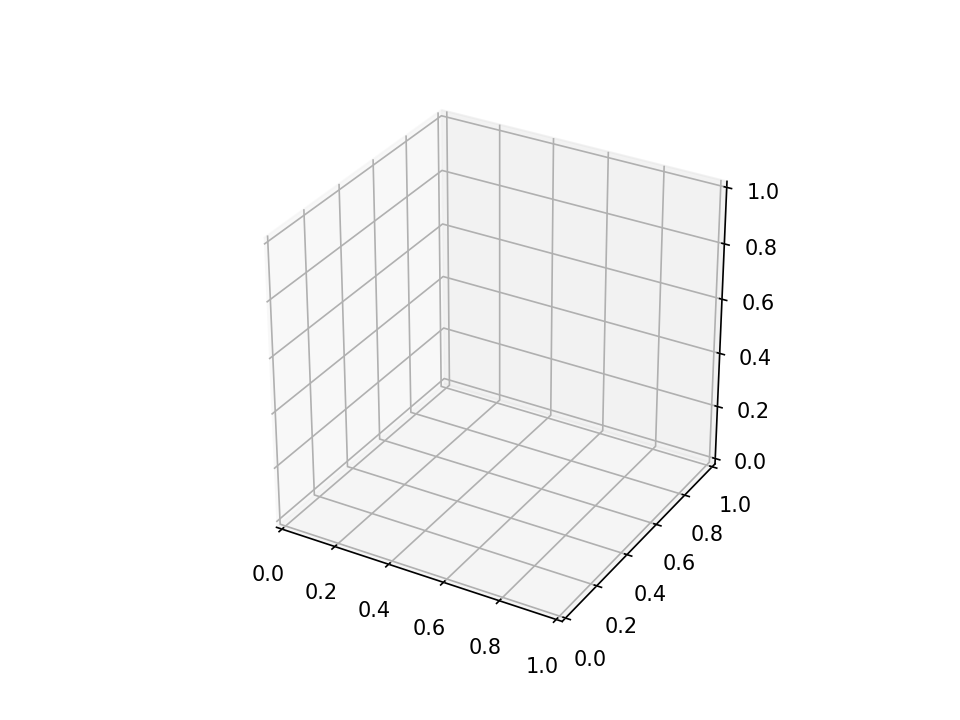

AttributeError: 'Line2D' object has no property 'cmap'

In [726]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

# plot the output
# plotLAB(lab_model_output,marker="o")
# plot the color chart
plotLAB(lab_color_chart,draw_polygon=True,marker="^")
# plot L = 50 surface
# plot_lab_plane(ax, L=50, a_range=(-128, 127, 100), b_range=(-128, 127, 100))

set_lab_color_space(ax)